# Basic NR waveform analyses

Illustrates the use of the `wave` and `mwaves` objects to work with BAM and Cactus/THC output waveforms.

SB 09/2021 core@uni-jena.de

## 0. Start

Clone the repo somewhere and install the package:

```
mkdir somewhere/
cd somehwere/
git clone git@git.tpi.uni-jena.de:core/watpy.git
cd watpy
python setup.py --user
```

Now look at the folders and see some files: they contain python code, functions and classes.

Go to the tutorial

```
cd tutorials
```

and find this tutorial.

The following assumes there is some test data in folders called `TestData/MySim_BAM_135135` and `TestData/MySim_THC_135135`. 
We will be writing some files, so along the way we will create few more folders inside those.

## 1. Load waveforms from a simulation and compute the strain

In [1]:
import os, sys
from watpy.wave.wave import * # wave() and mwave() objects
from watpy.utils.units import MSun_sec

You probably know all the details of what you have simulated with BAM ... so collect this info:

In [2]:
Msun_sec = MSun_sec() #4.925794970773135e-06

bamsim = {}
bamsim['folder'] = 'TestData/MySim_BAM_135135' # simulation folder
bamsim['mass'] = 2.700297e+00 # binary mass in solar masses
bamsim['q'] = 1.0 # mass ratio, >= 1
bamsim['Momg22'] = 3.789461e-02 # GW frequency (dim/less, mass rescaled)
bamsim['f0'] = bamsim['Momg22'] / (2*np.pi) / bamsim['mass'] # initial GW frequency in geom. units
bamsim['f0_Hz'] = bamsim['Momg22'] / (2*np.pi) / bamsim['mass']  / Msun_sec # initial GW frequency in Hz
bamsim['massA'] = 1.350149e+00
bamsim['massB'] = 1.350149e+00
bamsim['madm'] = 2.678040e+00 # ADM mass (t=0) 
bamsim['jadm'] = 7.858842e+00 # ADM ang.mom. (t=0) 
bamsim['MbA'] = 1.494607e+00
bamsim['MbB'] = 1.494607e+00
bamsim['level'] = 7
bamsim['levelm'] = 4
bamsim['nxyz'] = 320
bamsim['nmxyz'] = 128
bamsim['dxyz']= 7.520000e+00
bamsim['eos']= 'CSC'
# etc ...

bamsim['pre-release-folder'] = './TestData/MySim_BAM_135135/CoReDB' # folder with CoRe formatted files

#print(mysim['Momg22']) # 0.03789461

# Create folder for CoRe output
os.makedirs(bamsim['pre-release-folder'], exist_ok = True)

Next, we use watpy `wave` and `mwave` classes to compute few things from the $\Psi_4$ output modes. 

### Compute the strain of $(2,2)$ mode with the FFI and write files in CoRe format

In [3]:
w = wave(path = bamsim['folder'], code='bam', filename='Rpsi4mode22_r12.l0', 
         mass = bamsim['mass'], f0 = bamsim['f0'])

This does a few things behind the scenes, for example it computes the strain. Let'sask for it: 

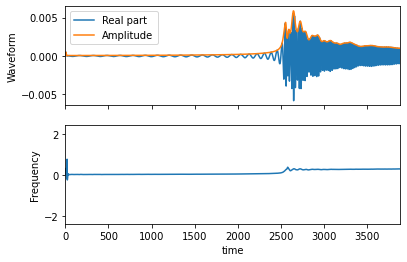

In [4]:
fig = w.show_psi4()

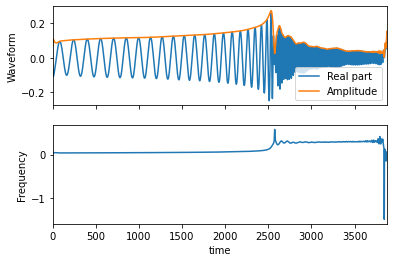

In [5]:
w.get_strain(fcut= bamsim['f0'])
fig = w.show_strain()

Now lets save the data in CoRe format and prepare them for a pre-release (check your folder afterwards)

In [6]:
w.write_to_txt('Psi4', bamsim['pre-release-folder'])
w.write_to_txt('h', bamsim['pre-release-folder'])

### Compute the strain with the FFI for many modes

Make a list of files containing the modes

In [7]:
import glob
fnames = [os.path.split(x)[1] for x in glob.glob('{}/{}'.format(bamsim['folder'],'Rpsi4mode??_r12.l0'))]
print(fnames)

['Rpsi4mode20_r12.l0', 'Rpsi4mode21_r12.l0', 'Rpsi4mode22_r12.l0', 'Rpsi4mode30_r12.l0', 'Rpsi4mode31_r12.l0', 'Rpsi4mode32_r12.l0', 'Rpsi4mode33_r12.l0', 'Rpsi4mode40_r12.l0', 'Rpsi4mode41_r12.l0', 'Rpsi4mode42_r12.l0', 'Rpsi4mode43_r12.l0', 'Rpsi4mode44_r12.l0']


Now we do pretty much the same as above but with the class for multipolar waveforms:

In [8]:
wm = mwaves(path = bamsim['folder'], code = 'bam', filenames = fnames, 
            mass = bamsim['mass'], f0 = bamsim['f0'], ignore_negative_m=True)

We can look again to the $(2,2)$ this way

In [9]:
h22 = wm.get(l=2,m=2)

or also check which modes are there and look at them this way:

In [10]:
print(wm.modes)

[(2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2), (3, 3), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]


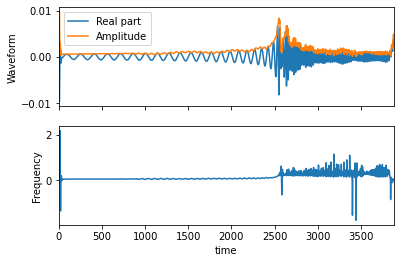

In [11]:
h32 = wm.get(l=3, m=2)
fig = h32.show_strain()

## 2. Write/read data in CoRe format

### Write to CoRe formatted `.txt` files

Now we save the modes in CoRe format:

In [12]:
for (l,m) in wm.modes:
        
        psilm = wm.get(var='Psi4',l=l, m=m)
        psilm.write_to_txt('Psi4', bamsim['pre-release-folder'])
        
        hlm = wm.get(l=l, m=m)
        hlm.write_to_txt('h', bamsim['pre-release-folder'])

... and also compute and write the energy curves

In [13]:
wm.energetics(bamsim['massA'], bamsim['massB'], bamsim['madm'], bamsim['jadm'], 
              path_out = bamsim['pre-release-folder'])

### Read from CoRe formatted `.txt` files

The `wave` class can also read CoRe format, obviously.

In [14]:
fnames = [os.path.split(x)[1] for x in glob.glob('{}/{}'.format(bamsim['pre-release-folder'],'Rh_l?_m?_r*.txt'))]
print(fnames)

['Rh_l2_m0_r00800.txt', 'Rh_l2_m1_r00800.txt', 'Rh_l2_m2_r00800.txt', 'Rh_l3_m0_r00800.txt', 'Rh_l3_m1_r00800.txt', 'Rh_l3_m2_r00800.txt', 'Rh_l3_m3_r00800.txt', 'Rh_l4_m0_r00800.txt', 'Rh_l4_m1_r00800.txt', 'Rh_l4_m2_r00800.txt', 'Rh_l4_m3_r00800.txt', 'Rh_l4_m4_r00800.txt']


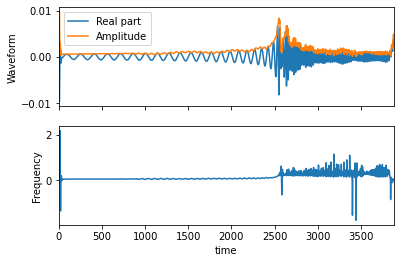

In [15]:
wm_c = mwaves(bamsim['pre-release-folder'], code = 'core', filenames = fnames, 
              mass = bamsim['mass'], f0 = bamsim['f0'], ignore_negative_m=True)
h32 = wm.get(l=3, m=2)
fig = h32.show_strain()

### HDF5 

Finally, we can create HDF5 data in CoRe format using the `CoRe_h5()` object

In [16]:
from watpy.utils.coreh5 import CoRe_h5
bamsim = {}
bamsim['pre-release-folder'] = './TestData/MySim_BAM_135135/CoReDB'

In [17]:
ch5 = CoRe_h5(bamsim['pre-release-folder'],None) # write .h5 to mysim['pre-release-folder'] ...

In [18]:
ch5.create(path=bamsim['pre-release-folder']) # ... all the CoRe .txt files in mysim['pre-release-folder']

wrote CoRe ./TestData/MySim_BAM_135135/CoReDB/data.h5


In [19]:
ch5.dump() # h5dump -n

energy
energy/EJ_r00800.txt
rh_20
rh_20/Rh_l2_m0_r00800.txt
rh_21
rh_21/Rh_l2_m1_r00800.txt
rh_22
rh_22/Rh_l2_m2_r00800.txt
rh_30
rh_30/Rh_l3_m0_r00800.txt
rh_31
rh_31/Rh_l3_m1_r00800.txt
rh_32
rh_32/Rh_l3_m2_r00800.txt
rh_33
rh_33/Rh_l3_m3_r00800.txt
rh_40
rh_40/Rh_l4_m0_r00800.txt
rh_41
rh_41/Rh_l4_m1_r00800.txt
rh_42
rh_42/Rh_l4_m2_r00800.txt
rh_43
rh_43/Rh_l4_m3_r00800.txt
rh_44
rh_44/Rh_l4_m4_r00800.txt
rpsi4_20
rpsi4_20/Rpsi4_l2_m0_r00800.txt
rpsi4_21
rpsi4_21/Rpsi4_l2_m1_r00800.txt
rpsi4_22
rpsi4_22/Rpsi4_l2_m2_r00800.txt
rpsi4_30
rpsi4_30/Rpsi4_l3_m0_r00800.txt
rpsi4_31
rpsi4_31/Rpsi4_l3_m1_r00800.txt
rpsi4_32
rpsi4_32/Rpsi4_l3_m2_r00800.txt
rpsi4_33
rpsi4_33/Rpsi4_l3_m3_r00800.txt
rpsi4_40
rpsi4_40/Rpsi4_l4_m0_r00800.txt
rpsi4_41
rpsi4_41/Rpsi4_l4_m1_r00800.txt
rpsi4_42
rpsi4_42/Rpsi4_l4_m2_r00800.txt
rpsi4_43
rpsi4_43/Rpsi4_l4_m3_r00800.txt
rpsi4_44
rpsi4_44/Rpsi4_l4_m4_r00800.txt


The `CoRe_h5()` object can help us to directly read datasets from the HDF5 and to visualize them:

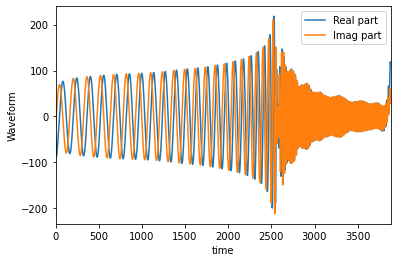

In [20]:
dset_h22 = ch5.read('rh_22')
fig, ax  = ch5.show('rh_22')

The create/read methods of the `CoRe_h5()` object are somehow specific for the waveform and energy data and for the file format of the CoRe DB. However, in general, there are more data that we want to store as h5 (either in the CoRe DB or for other purposes). We can use the more general methods create_dset/read_dset to create the simple .h5 file with groups/datasets. In case we want to use this for the CoRe DB, we just need to pay some attention to the names we give to the groups and to which files we pass, but this way we have more flexibility.

It works as in the following:

In [21]:
# make a list of groups and files for each group
bamdat = {}
bamdat['energy'] = ['EJ_r00800.txt']
bamdat['rh_22'] = ['Rh_l2_m2_r00800.txt']
bamdat['rh_30'] = ['Rh_l3_m0_r00800.txt']
bamdat['rpsi4_20'] = ['Rpsi4_l2_m0_r00800.txt','Rpsi4_l2_m0_r00800.txt']
bamdat['rpsi4_22'] = ['Rpsi4_l2_m2_r00800.txt','Rpsi4_l2_m2_r00800.txt']
# etc ...

# and create a h5 'bis' with the create_dset method
ch5_bis = CoRe_h5(bamsim['pre-release-folder'], None)
ch5_bis.create_dset(bamdat, path=bamsim['pre-release-folder'], dfile = 'data_bis.h5')

Now lets check inside and read again:

In [22]:
ch5_bis.dump()

dset_bis = ch5_bis.read_dset()

print(dset_bis.keys())
print(dset_bis['rpsi4_22'].keys())
print(dset_bis['rpsi4_22']['Rpsi4_l2_m2_r00800.txt'])

energy
energy/EJ_r00800.txt
rh_22
rh_22/Rh_l2_m2_r00800.txt
rh_30
rh_30/Rh_l3_m0_r00800.txt
rpsi4_20
rpsi4_20/Rpsi4_l2_m0_r00800.txt
rpsi4_22
rpsi4_22/Rpsi4_l2_m2_r00800.txt
dict_keys(['energy', 'rh_22', 'rh_30', 'rpsi4_20', 'rpsi4_22'])
dict_keys(['Rpsi4_l2_m2_r00800.txt'])
[[-3.06246366e+02  1.03838571e-06 -1.62943639e-05 ...  1.63274168e-05
   1.50715570e+00  0.00000000e+00]
 [-3.05550146e+02  1.04313477e-06 -1.63328982e-05 ...  1.63661753e-05
   1.50701586e+00  1.88000000e+00]
 [-3.04853926e+02  1.05291821e-06 -1.63714756e-05 ...  1.64052995e-05
   1.50657059e+00  3.76000000e+00]
 ...
 [ 3.87942654e+03 -2.26716774e-01  1.94139538e-01 ...  2.98480579e-01
   5.31637304e+02  1.13025600e+04]
 [ 3.88012276e+03 -1.80401371e-01  2.38096051e-01 ...  2.98721248e-01
   5.31851555e+02  1.13044400e+04]
 [ 3.88081898e+03 -1.25731785e-01  2.71015211e-01 ...  2.98760316e-01
   5.32065578e+02  1.13063200e+04]]


The use *_dset is the preferred method to create .h5 for the CoRe DB.

## 3. Metadata

Here we give an example on how to write metadata in CoRe format. Something like this must be, for example, every time a new simulations needs to the added to the CoRe DB (see the tutorial `watpy_CoReDB.ipynb`)

 First of all, all the steps above in 2. can be of course done also for a Cactus/THC simulation. We repeat few of them here:

wrote CoRe ./TestData/MySim_THC_135135/CoReDB/data.h5


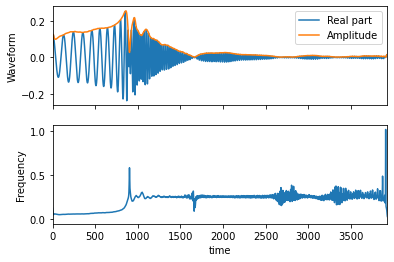

In [23]:
from watpy.wave.wave import wave, mwaves
from watpy.utils import ioutils
import numpy as np
import os, glob

thcsim = {}
thcsim['folder'] = './TestData/MySim_THC_135135' # simulation folder
thcsim['mass'] = 2 * 1.364 # binary mass in solar masses
thcsim['q'] = 1.0 # mass ratio, >= 1
thcsim['f0_Hz'] = 565.08 # initial GW frequency in Hz
thcsim['f0'] = thcsim['f0_Hz'] * Msun_sec
thcsim['Momg22'] = thcsim['mass'] * thcsim['f0'] / (2*np.pi) # initial GW frequency in geom. units
thcsim['massA'] = 1.364
thcsim['massB'] = 1.364
thcsim['madm'] = 2.703 # ADM mass (t=0) 
thcsim['jadm'] = 7.400 # ADM ang.mom. (t=0) 
# etc
thcsim['id_code']                  = 'LORENE'
thcsim['id_type']                  = 'Irrotational'
thcsim['id_mass']                  = 2.7
thcsim['id_rest_mass']             = 2.94554
thcsim['id_mass_ratio']            = 1.0
thcsim['id_ADM_mass']              = 2.67288
thcsim['id_ADM_angularmomentum']   = 7.01514
thcsim['id_gw_frequency_Hz']       = 663.58
thcsim['id_gw_frequency_Momega22'] = 0.0554514940011
thcsim['id_eos']                   = 'ABC'
thcsim['id_kappa2T']               = 159.0084296249798
thcsim['id_Lambda']                = 848.0449579998918
thcsim['id_eccentricity']          = None 
thcsim['id_mass_starA']            = 1.35
thcsim['id_rest_mass_starA']       = 1.47277
thcsim['id_spin_starA']            = 0, 0, 0
thcsim['id_LoveNum_kell_starA']    = 0.09996, 0.0269, 0.00984
thcsim['id_Lambdaell_starA']       = 848.0449579998921, 2001.0063178210328, 4584.234164607441
thcsim['id_mass_starB']            = 1.35
thcsim['id_rest_mass_starB']       = 1.47277

thcsim['pre-release-folder'] = './TestData/MySim_THC_135135/CoReDB' # folder with CoRe formatted files

# Create folder for CoRe output
os.makedirs(thcsim['pre-release-folder'], exist_ok = True)

fnames = [os.path.split(x)[1] for x in glob.glob('{}/{}'.format(thcsim['folder'],'mp_Psi4_l?_m?_r400.00.asc'))]

wm = mwaves(path = thcsim['folder'], code = 'cactus', filenames = fnames, 
            mass = thcsim['mass'], f0 = thcsim['f0'], ignore_negative_m=True)

h22 = wm.get(l=2, m=2)
fig = h22.show_strain()

for (l,m) in wm.modes:
    
        psilm = wm.get(var='Psi4',l=l, m=m)
        psilm.write_to_txt('Psi4', thcsim['pre-release-folder'])
        
        hlm = wm.get(l=l, m=m)
        hlm.write_to_txt('h', thcsim['pre-release-folder'])

wm.energetics(thcsim['massA'], thcsim['massB'], thcsim['madm'], thcsim['jadm'], 
              path_out = thcsim['pre-release-folder'])

# etc ...

# write .h5
ch5 = CoRe_h5(thcsim['pre-release-folder'],None) 
ch5.create(path=thcsim['pre-release-folder'])

In the section above the `thcsim` dictionary is (carefully) written using (some of) the keys for the CoRe DB metadata. The latter are stored in a `CoRe_md()` object, which basically contains a dictionary. Lets see what is inside:

In [24]:
from watpy.coredb.metadata import CoRe_md

md = CoRe_md() # initialized empty
print(md.path)
print(md.data)

md.info() # describes the metadata

.
{'database_key': '', 'simulation_name': '', 'available_resolutions': None, 'reference_bibkeys': '', 'id_code': '', 'id_type': '', 'id_mass': '', 'id_rest_mass': '', 'id_mass_ratio': '', 'id_ADM_mass': '', 'id_ADM_angularmomentum': '', 'id_gw_frequency_Hz': '', 'id_gw_frequency_Momega22': '', 'id_eos': '', 'id_kappa2T': '', 'id_Lambda': '', 'id_mass_starA': '', 'id_rest_mass_starA': '', 'id_spin_starA': '', 'id_LoveNum_kell_starA': '', 'id_Lambdaell_starA': '', 'id_mass_starB': '', 'id_rest_mass_starB': '', 'id_spin_starB': '', 'id_LoveNum_kell_starB': '', 'id_Lambdaell_starB': '', 'id_eccentricity': '', 'evolution_code': '', 'grid_refinement_levels': '', 'grid_refinement_levels_moving': '', 'grid_refinement_levels_npoints': '', 'grid_refinement_levels_moving_npoints': '', 'grid_spacing_min': '', 'grid_symmetries': '', 'grid_shells': '', 'grid_shells_radial_npoints': '', 'grid_shells_angular_npoints': '', 'grid_conservative_amr': '', 'metric_scheme': '', 'metric_boundary_conditions': 

To initialize this object we can either pass a text file like

```

# comment
key = value
...

```

or a dictionary, like `thcsim`. Lets do the latter thing and then use the `CoRe_md()` to write such a text file, i.e. a `metadata.txt`:

In [25]:
md.update_fromdict(thcsim)
# md = CoRe_md(metadata = thcsim) # alternatively, (re-)initialize

# show the metadata
for k,v, in md.data.items():
    print('{} = {}'.format(k,v))

# write
md.write(path = thcsim['pre-release-folder'], fname = 'metadata.txt')

database_key = 
simulation_name = 
available_resolutions = None
reference_bibkeys = 
id_code = LORENE
id_type = Irrotational
id_mass = 2.7
id_rest_mass = 2.94554
id_mass_ratio = 1.0
id_ADM_mass = 2.67288
id_ADM_angularmomentum = 7.01514
id_gw_frequency_Hz = 663.58
id_gw_frequency_Momega22 = 0.0554514940011
id_eos = ABC
id_kappa2T = 159.0084296249798
id_Lambda = 848.0449579998918
id_mass_starA = 1.35
id_rest_mass_starA = 1.47277
id_spin_starA = (0, 0, 0)
id_LoveNum_kell_starA = (0.09996, 0.0269, 0.00984)
id_Lambdaell_starA = (848.0449579998921, 2001.0063178210328, 4584.234164607441)
id_mass_starB = 1.35
id_rest_mass_starB = 1.47277
id_spin_starB = 
id_LoveNum_kell_starB = 
id_Lambdaell_starB = 
id_eccentricity = None
evolution_code = 
grid_refinement_levels = 
grid_refinement_levels_moving = 
grid_refinement_levels_npoints = 
grid_refinement_levels_moving_npoints = 
grid_spacing_min = 
grid_symmetries = 
grid_shells = 
grid_shells_radial_npoints = 
grid_shells_angular_npoints = 
grid_co